In [1]:
from abc import ABC, abstractmethod
from typing import Dict, List
import warnings

# Работа с таблицам
import numpy as np
import pandas as pd
import seaborn as sns

# Пакеты для сollaborative filtering (я работал с пакетом implicit)
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization

# Вспомогательные пакеты
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.preprocessing import LabelEncoder

# Методы для content-based filtering
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

# Визуализация/из
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## Данные

В качестве данных будем использовать датасет от MTS.AI: kion-data.
Это информация о просмотрах пользователей различных фильмов и сериалов с названиями, описаниями и прочими фичами.

Таблица Users
* Признаки

    * user_id – индентификатор пользователя, уникален для каждого
    * age – категориальный признак, показывающий возрастную группу пользователя
    * income – категориальный признак, показывающий зарплатную группу пользователя
    * sex – пол пользователя
    * kids_flg – наличие детей у пользователя

Таблица Items
* Признаки
    * item_id – индентификатор айтема, уникален для каждого
    * content_type – категориальный признак, тип айтема (фильм, сериал и т.д.)
    * title – Название на русском языке
    * title_orig – Название на языке оригинала
    * release_year – год выхода
    * genres – список жанров (представлен строкой)
    * countries – страна издания
    * for_kids – предназначен для детей
    * age_rating – возрастной рейтинг картины
    * studios – студия, выпустившая картину
    * directors – режиссер(ы)
    * actors – актёры
    * description – описание (на русском)
    * keywords – ключевые слова, описывающие картину


In [2]:
def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "ground_truth") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

## Feature engineering

In [3]:
def percent_missing(my_df):
    result = 100*my_df.isnull().sum()/len(my_df)
    result = result[result>0].sort_values()
    return result

## Анализ items

In [4]:
items_dataset = pd.read_csv('items.csv')

In [5]:
items_dataset.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,11114,film,Принцесса Лебедь: Пират или принцесса,"The Swan Princess: Princess Tomorrow, Pirate T...",2016.0,"для детей, сказки, полнометражные, зарубежные,...",США,NaN,6.0,Sony Pictures,Ричард Рич,"Брайан Ниссен, Гарднер Джаэс, Грант Дураззо, Д...",Анимационная сказка о непоседливой принцессе Э...,"Принцесса, Лебедь, Пират, или, принцесса, 2016..."


In [6]:
for col in items_dataset.columns:
    if col not in ['title_orig', 'title', 'item_id', 'genres', 'actors', 'description', 'keywords', 'countries']:
        print(pd.unique(items_dataset[col]))

['film' 'series']
[2002. 2014. 2011. 2015. 2016. 2018. 2013. 1987. 2019. 2020. 2007. 1975.
 2010. 2012. 1999. 1976. 1991. 2004. 2003. 2001. 2017. 2009. 2008. 1993.
 2000. 1954. 2021. 1997. 2006. 2005. 1981. 1990. 1994. 1989. 1939. 1935.
 1995. 1984. 1980. 1974. 1986. 1963. 1962. 1978. 1982. 1958. 1988. 1961.
 1971. 1969. 1979. 1970. 1955. 1998. 1992. 1942. 1985. 1983. 1965. 1959.
 1964.   nan 1941. 1952. 1953. 1938. 1967. 1920. 1943. 1948. 1972. 1973.
 1947. 1966. 1977. 1931. 1968. 1956. 1957. 1996. 1946. 1921. 1960. 1937.
 1926. 1933. 1945. 1934. 1951. 1936. 1944. 1929. 1918. 1932. 1927. 1917.
 1940. 1949. 1924. 1916. 1950. 1922. 1930.]
[nan  0.  1.]
[16.  6. 12. 18.  0. 21. nan]
[nan 'Sony Pictures' 'Ленфильм' 'Starz' 'BBC' 'HBO' 'Paramount'
 'Universal' 'Sky' 'Cinemax' 'CBS' 'Ленфильм, рентв' 'Sony Plus, рентв'
 'FX' 'Sky, Fremantle' 'DAZN' 'Warner Bros' 'Fremantle'
 'Sony Pictures, рентв' 'Fox' 'HBO, BBC' 'Мосфильм' 'Showtime' 'Endemol'
 'Sony Pictures Television' 'CBS All Access' 

In [7]:
items_dataset.columns

Index(['item_id', 'content_type', 'title', 'title_orig', 'release_year',
       'genres', 'countries', 'for_kids', 'age_rating', 'studios', 'directors',
       'actors', 'description', 'keywords'],
      dtype='object')

In [8]:
items_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12067 entries, 0 to 12066
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       12067 non-null  int64  
 1   content_type  12067 non-null  object 
 2   title         12067 non-null  object 
 3   title_orig    9144 non-null   object 
 4   release_year  12019 non-null  float64
 5   genres        12067 non-null  object 
 6   countries     12051 non-null  object 
 7   for_kids      528 non-null    float64
 8   age_rating    12066 non-null  float64
 9   studios       749 non-null    object 
 10  directors     11160 non-null  object 
 11  actors        10268 non-null  object 
 12  description   12066 non-null  object 
 13  keywords      11705 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.3+ MB


In [9]:
items_dataset.isnull().sum()

item_id             0
content_type        0
title               0
title_orig       2923
release_year       48
genres              0
countries          16
for_kids        11539
age_rating          1
studios         11318
directors         907
actors           1799
description         1
keywords          362
dtype: int64

In [10]:
total_duplicate_titles = sum(items_dataset.duplicated())
print(f"There are {total_duplicate_titles} duplicate rows.")

There are 0 duplicate rows.


In [11]:
items_dataset['genres'] = items_dataset['genres'].str.split(' ,').explode()

In [12]:
# items_dataset.head()

In [13]:
items_dataset['actors'] = items_dataset['actors'].str.split(' ,')

In [14]:
items_dataset['keywords'] = items_dataset['keywords'].str.split(' ,')

In [15]:
items_dataset['directors'] = items_dataset['directors'].str.split(' ,').explode()

In [16]:
items_dataset['description'] = items_dataset['description'].str.split(' ')

In [17]:
items_dataset['countries'] = items_dataset['countries'].str.split(' ,').explode()

In [18]:
items_dataset.describe()

,item_id,release_year,for_kids,age_rating
count,12067.000000,12019.000000,528.000000,12066.000000
mean,8275.688324,2009.369415,0.200758,13.278800
std,4784.091799,15.125133,0.400947,5.403964
min,0.000000,1916.000000,0.000000,0.000000
25%,4128.500000,2008.000000,0.000000,12.000000
50%,8260.000000,2015.000000,0.000000,16.000000
75%,12447.000000,2018.000000,0.000000,16.000000
max,16518.000000,2021.000000,1.000000,21.000000


In [19]:
items_dataset.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"[Адольфо Фернандес, Ана Фернандес, Дарио Гранд...","[Мелодрама, легендарного, Педро, Альмодовара, ...","[Поговори, ней, 2002, Испания, друзья, любовь,..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"[Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон...","[Уморительная, современная, комедия, на, попул...","[Голые, перцы, 2014, США, друзья, свадьбы, пре..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"[Адриан Холмс, Даррен Шалави, Джерри Вассерман...","[Профессиональный, рестлер, Стив, Остин, («Все...","[Тактическая, сила, 2011, Канада, бандиты, ган..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"[Александра Риддлстон-Барретт, Джеральдин Джей...","[Шарлотта, Рэмплинг,, Том, Кортни,, Джеральдин...","[45, лет, 2015, Великобритания, брак, жизнь, л..."
4,11114,film,Принцесса Лебедь: Пират или принцесса,"The Swan Princess: Princess Tomorrow, Pirate T...",2016.0,"для детей, сказки, полнометражные, зарубежные,...",США,NaN,6.0,Sony Pictures,Ричард Рич,"[Брайан Ниссен, Гарднер Джаэс, Грант Дураззо, ...","[Анимационная, сказка, о, непоседливой, принце...","[Принцесса, Лебедь, Пират, или, принцесса, 201..."


In [20]:
items_dataset.isna().sum()

item_id             0
content_type        0
title               0
title_orig       2923
release_year       48
genres              0
countries          16
for_kids        11539
age_rating          1
studios         11318
directors         907
actors           1799
description         1
keywords          362
dtype: int64

In [21]:
percent_nan = percent_missing(items_dataset)

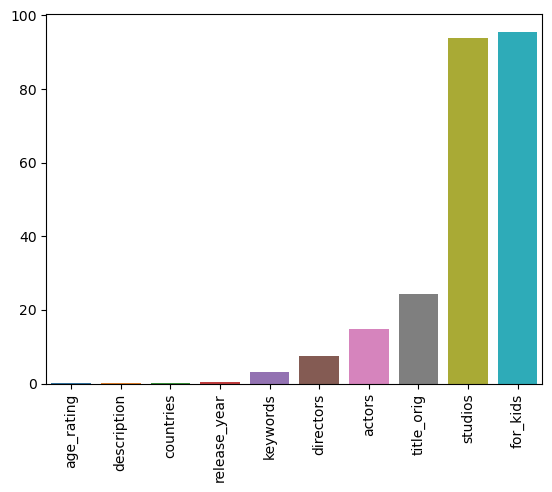

In [22]:
# рассчитываем процент пропущенных значений
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation = 90);

* Заметим, что title_orig содержит много пропущенных значений, в то же время в title нет ни одного пропущенного7 Поэтому будет брать ее в качетсве итогового колонки (также в ключевых словах названия фильмов на русском языке, как и в колонке title)
* Аналогичная итория и с 'for kids'(заметим, что nan в данном случае - пропущенное значение), 'studios'. То есть в финальный датасет они не попадут

In [23]:
items_dataset = items_dataset.drop(columns=['for_kids', 'studios', 'title_orig'])

In [24]:
# items_dataset['for_kids'].unique()

In [25]:
# items_dataset[items_dataset['age_rating'].isnull()]
# Только у одномого фильма отсутвуют данные, его мы удалим

In [26]:
# items_dataset[items_dataset['description'].isnull()]
# Только у одномого фильма отсутвуют данные, его мы удалим

In [27]:
# items_dataset[items_dataset['countries'].isnull()]
# Только маленький процент строк имеет nan в 'countries'(также как можно заметить, у них отсутвуют и ряд других данных)
# Поэтому можно их удалить

In [28]:
items_dataset = items_dataset.dropna(axis=0, subset=['description', 'age_rating', 'countries', 'release_year'])

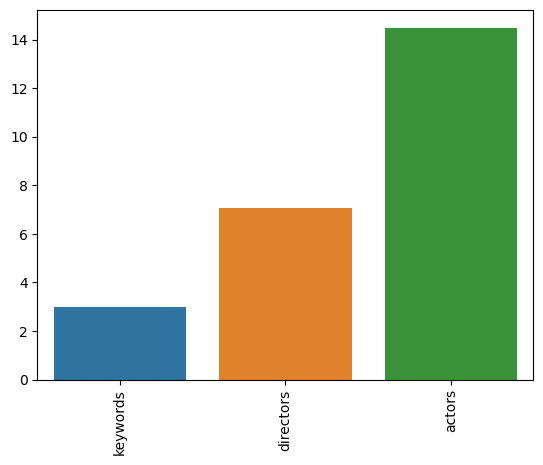

In [29]:
percent_nan = percent_missing(items_dataset)
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation = 90);

In [30]:
items_dataset['directors'].fillna("Неизвестен")
items_dataset['actors'].fillna("Неизвестен")
items_dataset['keywords'].fillna("Неизвестен")

0        [Поговори, ней, 2002, Испания, друзья, любовь,...
1        [Голые, перцы, 2014, США, друзья, свадьбы, пре...
2        [Тактическая, сила, 2011, Канада, бандиты, ган...
3        [45, лет, 2015, Великобритания, брак, жизнь, л...
4        [Принцесса, Лебедь, Пират, или, принцесса, 201...
                               ...                        
12062    [убийство, вирус, расследование преступления, ...
12063                              [Надежда, 2020, Россия]
12064                               [Сговор, 2017, Россия]
12065                        [Среди, камней, 2019, Россия]
12066                                 [Гоша, 2019, Россия]
Name: keywords, Length: 12007, dtype: object

In [31]:
items_dataset.isna().sum()

item_id            0
content_type       0
title              0
release_year       0
genres             0
countries          0
age_rating         0
directors        849
actors          1742
description        0
keywords         361
dtype: int64

In [32]:
items_dataset.head()

,item_id,content_type,title,release_year,genres,countries,age_rating,directors,actors,description,keywords
0,10711,film,Поговори с ней,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,16.0,Педро Альмодовар,"[Адольфо Фернандес, Ана Фернандес, Дарио Гранд...","[Мелодрама, легендарного, Педро, Альмодовара, ...","[Поговори, ней, 2002, Испания, друзья, любовь,..."
1,2508,film,Голые перцы,2014.0,"зарубежные, приключения, комедии",США,16.0,Скот Армстронг,"[Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон...","[Уморительная, современная, комедия, на, попул...","[Голые, перцы, 2014, США, друзья, свадьбы, пре..."
2,10716,film,Тактическая сила,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,16.0,Адам П. Калтраро,"[Адриан Холмс, Даррен Шалави, Джерри Вассерман...","[Профессиональный, рестлер, Стив, Остин, («Все...","[Тактическая, сила, 2011, Канада, бандиты, ган..."
3,7868,film,45 лет,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,16.0,Эндрю Хэй,"[Александра Риддлстон-Барретт, Джеральдин Джей...","[Шарлотта, Рэмплинг,, Том, Кортни,, Джеральдин...","[45, лет, 2015, Великобритания, брак, жизнь, л..."
4,11114,film,Принцесса Лебедь: Пират или принцесса,2016.0,"для детей, сказки, полнометражные, зарубежные,...",США,6.0,Ричард Рич,"[Брайан Ниссен, Гарднер Джаэс, Грант Дураззо, ...","[Анимационная, сказка, о, непоседливой, принце...","[Принцесса, Лебедь, Пират, или, принцесса, 201..."


## Анализ Users

In [33]:
users_dataset = pd.read_csv('users.csv')

In [34]:
users_dataset.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,721985,age_45_54,income_20_40,Ж,0
3,704055,age_35_44,income_60_90,Ж,0
4,846063,age_35_44,income_40_60,Ж,1


In [35]:
users_dataset.describe()

,user_id,kids_flg
count,3.660880e+05,366088.000000
mean,5.488215e+05,0.324572
std,3.168316e+05,0.468215
min,0.000000e+00,0.000000
25%,2.741042e+05,0.000000
50%,5.491840e+05,0.000000
75%,8.229505e+05,1.000000
max,1.097557e+06,1.000000


In [36]:
users_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366088 entries, 0 to 366087
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   366088 non-null  int64 
 1   age       362506 non-null  object
 2   income    362739 non-null  object
 3   sex       362027 non-null  object
 4   kids_flg  366088 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 14.0+ MB


In [37]:
for column in users_dataset.columns:
    if column != 'user_id':
        print(f'Столбец {column} имеет следующие категории:', users_dataset[column].unique())

Столбец age имеет следующие категории: ['age_25_34' 'age_18_24' 'age_45_54' 'age_35_44' 'age_55_64' 'age_65_inf'
 nan]
Столбец income имеет следующие категории: ['income_60_90' 'income_20_40' 'income_40_60' 'income_90_150'
 'income_0_20' nan 'income_150_inf']
Столбец sex имеет следующие категории: ['М' 'Ж' nan]
Столбец kids_flg имеет следующие категории: [1 0]


In [38]:
users_dataset.isnull().sum()

user_id        0
age         3582
income      3349
sex         4061
kids_flg       0
dtype: int64

In [39]:
total_duplicate_titles = sum(users_dataset.duplicated())
print(f"There are {total_duplicate_titles} duplicate rows.")

There are 0 duplicate rows.


In [40]:
percent_nan = percent_missing(users_dataset)

In [41]:
percent_nan

income    0.914807
age       0.978453
sex       1.109296
dtype: float64

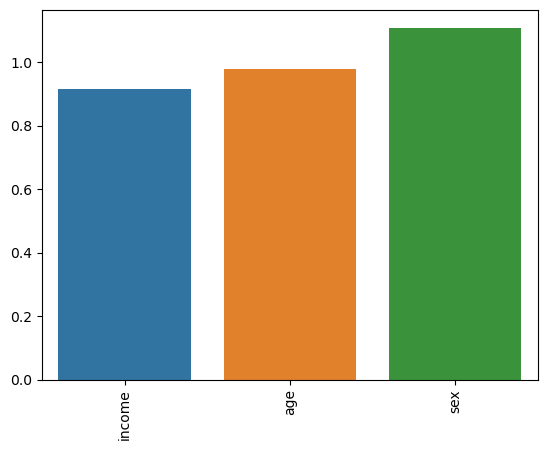

In [42]:
# рассчитываем процент пропущенных значений
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation = 90);

In [43]:
print('Number of Nan in Income column', len(users_dataset[users_dataset['income'].isnull()]))
print('Number of Nan in Age column', len(users_dataset[users_dataset['age'].isnull()]))
print('Number of Nan in Sex column', len(users_dataset[users_dataset['sex'].isnull()]))
print('Number of Nan in Income&Age&Sex column', len(users_dataset[users_dataset['income'].isnull() & users_dataset['age'].isnull() & users_dataset['sex'].isnull()]))

Number of Nan in Income column 3349
Number of Nan in Age column 3582
Number of Nan in Sex column 4061
Number of Nan in Income&Age&Sex column 2963


Заметим, что процент пропущенных данных в этих колонках равен приблизительно 1%. Удаление этих данных не сильно повлияет на исходный массив, однако сделает recsys более точной

In [44]:
users_dataset = users_dataset.dropna(axis=0, subset=['income', 'age', 'sex'])

In [45]:
users_dataset.isnull().sum()

user_id     0
age         0
income      0
sex         0
kids_flg    0
dtype: int64

<AxesSubplot:>

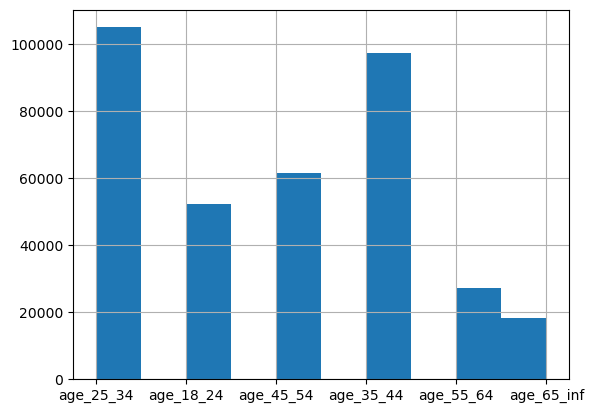

In [46]:
users_dataset['age'].hist()

## Анализ train_data

In [47]:
train_dataset = pd.read_csv('train_data.csv')

In [48]:
train_dataset.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0


In [49]:
train_dataset.describe()

,user_id,item_id,total_dur,watched_pct
count,1.224560e+06,1.224560e+06,1.224560e+06,1.224295e+06
mean,5.491677e+05,8.489881e+03,8.655139e+03,4.842976e+01
std,3.166305e+05,4.753527e+03,3.251046e+04,4.251957e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.750000e+05,4.285000e+03,3.890000e+02,5.000000e+00
50%,5.498290e+05,8.784000e+03,3.431000e+03,3.800000e+01
75%,8.225870e+05,1.268600e+04,7.401000e+03,1.000000e+02
max,1.097557e+06,1.651800e+04,6.147245e+06,1.000000e+02


In [50]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224560 entries, 0 to 1224559
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user_id        1224560 non-null  int64  
 1   item_id        1224560 non-null  int64  
 2   last_watch_dt  1224560 non-null  object 
 3   total_dur      1224560 non-null  float64
 4   watched_pct    1224295 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 46.7+ MB


In [51]:
train_dataset.isnull().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      265
dtype: int64

In [52]:
train_dataset = train_dataset.dropna(axis=0, subset=['watched_pct'])

In [53]:
train_dataset.isnull().sum()

user_id          0
item_id          0
last_watch_dt    0
total_dur        0
watched_pct      0
dtype: int64

## Merging all data

In [54]:
# df = pd.merge(left = train_dataset, right = items_dataset, how = 'inner', on = 'item_id')

In [55]:
# df = pd.merge(df, users_dataset, how = 'inner', on = 'user_id')

In [56]:
# df.head()

## Exploratory data analysis (EDA)

In [57]:
# df.corr()

<AxesSubplot:xlabel='content_type', ylabel='count'>

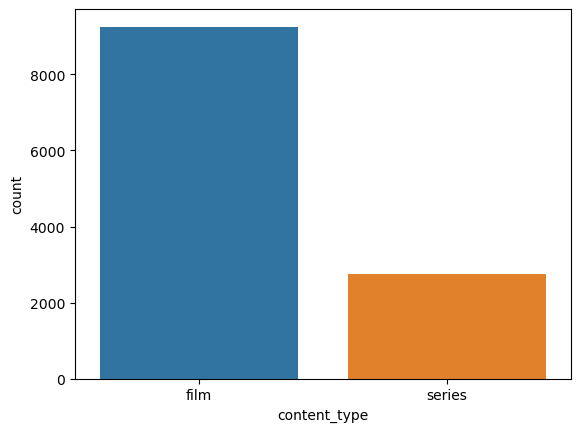

In [58]:
sns.countplot(data = items_dataset, x = 'content_type')

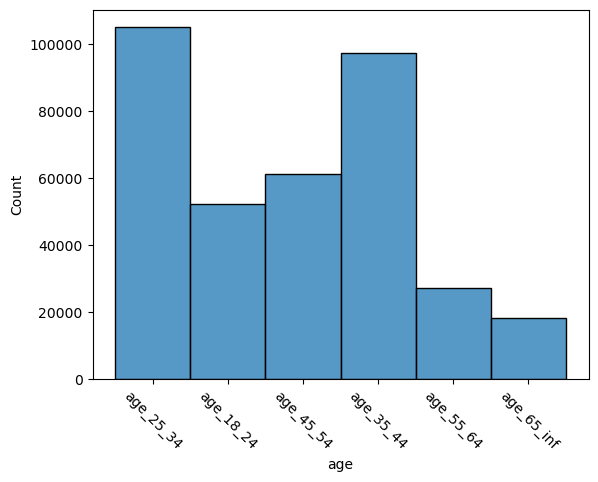

In [59]:
sns.histplot(data=users_dataset, x = 'age')
plt.xticks(rotation=-45);

<AxesSubplot:xlabel='sex', ylabel='Count'>

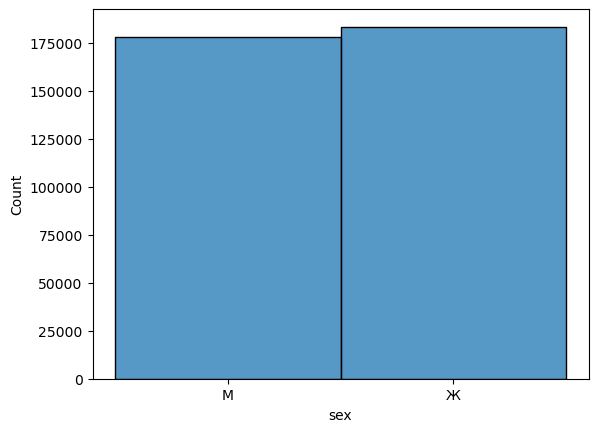

In [60]:
sns.histplot(data=users_dataset, x = 'sex')

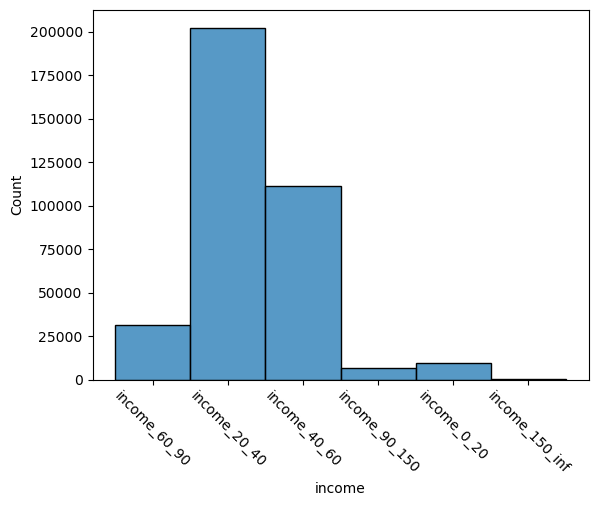

In [61]:
sns.histplot(data=users_dataset, x = 'income')
plt.xticks(rotation=-45);

Стоит отметить, что есть разные виды рекомедательных систем (спасибо кейсу от Тинькофф, который подтолкнул разобраться с ними)
* Demographic Filtering: Обобщенные рекомендации, которые никак не персоналихированы. Слишком простая и не эффективная модель
* Content-based Filtering: здесь рекомендации строятся на основе метаданных. Если пользователю нравится элемент, то ему нравятся и похожие на него предметы
* Collaboration-based Filtering: идет группировка пользователей по общим интересам

В своей работе я рассмотрю 2 последние модели и сравню их основные метрики между собой 

## Content-based Filtering
в качестве параметров возьмем ['title', 'genres', 'counries', 'directors', 'keyword', 'actors'] из таблицы items

In [62]:
def clean_data(row):
    if isinstance(row, list):
        return [str.lower(i.replace(" ", "")) for i in row]
    else:
        if isinstance(row, str):
            return str.lower(row.replace(" ", ""))
        else:
            return ""
        

def create_soup(features):
    return ' '.join(features['keywords']) + ' ' + ' '.join(features['actors']) + ' ' + features['directors'] + ' ' + ' '.join(features['genres']) + ' ' + ' '.join(features['countries'])

In [63]:
items_dataset_copy = items_dataset.copy()
features = ['genres', 'countries', 'directors', 'keywords', 'actors'] 
for feature in features:
    items_dataset_copy[feature] = items_dataset_copy[feature].apply(clean_data)

In [64]:
items_dataset_copy["soup"] = items_dataset_copy.apply(create_soup, axis = 1)

In [65]:
rus_stop_words = stop_words = ["а","е","и","ж","м","о","на","не","ни","об","но","он","мне","мои","мож","она","они","оно","мной","много","многочисленное","многочисленная","многочисленные","многочисленный","мною","мой","мог","могут","можно","может","можхо","мор","моя","моё","мочь","над","нее","оба","нам","нем","нами","ними","мимо","немного","одной","одного","менее","однажды","однако","меня","нему","меньше","ней","наверху","него","ниже","мало","надо","один","одиннадцать","одиннадцатый","назад","наиболее","недавно","миллионов","недалеко","между","низко","меля","нельзя","нибудь","непрерывно","наконец","никогда","никуда","нас","наш","нет","нею","неё","них","мира","наша","наше","наши","ничего","начала","нередко","несколько","обычно","опять","около","мы","ну","нх","от","отовсюду","особенно","нужно","очень","отсюда","в","во","вон","вниз","внизу","вокруг","вот","восемнадцать","восемнадцатый","восемь","восьмой","вверх","вам","вами","важное","важная","важные","важный","вдали","везде","ведь","вас","ваш","ваша","ваше","ваши","впрочем","весь","вдруг","вы","все","второй","всем","всеми","времени","время","всему","всего","всегда","всех","всею","всю","вся","всё","всюду","г","год","говорил","говорит","года","году","где","да","ее","за","из","ли","же","им","до","по","ими","под","иногда","довольно","именно","долго","позже","более","должно","пожалуйста","значит","иметь","больше","пока","ему","имя","пор","пора","потом","потому","после","почему","почти","посреди","ей","два","две","двенадцать","двенадцатый","двадцать","двадцатый","двух","его","дел","или","без","день","занят","занята","занято","заняты","действительно","давно","девятнадцать","девятнадцатый","девять","девятый","даже","алло","жизнь","далеко","близко","здесь","дальше","для","лет","зато","даром","первый","перед","затем","зачем","лишь","десять","десятый","ею","её","их","бы","еще","при","был","про","процентов","против","просто","бывает","бывь","если","люди","была","были","было","будем","будет","будете","будешь","прекрасно","буду","будь","будто","будут","ещё","пятнадцать","пятнадцатый","друго","другое","другой","другие","другая","других","есть","пять","быть","лучше","пятый","к","ком","конечно","кому","кого","когда","которой","которого","которая","которые","который","которых","кем","каждое","каждая","каждые","каждый","кажется","как","какой","какая","кто","кроме","куда","кругом","с","т","у","я","та","те","уж","со","то","том","снова","тому","совсем","того","тогда","тоже","собой","тобой","собою","тобою","сначала","только","уметь","тот","тою","хорошо","хотеть","хочешь","хоть","хотя","свое","свои","твой","своей","своего","своих","свою","твоя","твоё","раз","уже","сам","там","тем","чем","сама","сами","теми","само","рано","самом","самому","самой","самого","семнадцать","семнадцатый","самим","самими","самих","саму","семь","чему","раньше","сейчас","чего","сегодня","себе","тебе","сеаой","человек","разве","теперь","себя","тебя","седьмой","спасибо","слишком","так","такое","такой","такие","также","такая","сих","тех","чаще","четвертый","через","часто","шестой","шестнадцать","шестнадцатый","шесть","четыре","четырнадцать","четырнадцатый","сколько","сказал","сказала","сказать","ту","ты","три","эта","эти","что","это","чтоб","этом","этому","этой","этого","чтобы","этот","стал","туда","этим","этими","рядом","тринадцать","тринадцатый","этих","третий","тут","эту","суть","чуть","тысяч"] + list(np.arange(1,2023))

In [66]:
count_vectorizer = TfidfVectorizer(stop_words=rus_stop_words) #удаляем все русский стоп слова

In [67]:
count_matrix = count_vectorizer.fit_transform(items_dataset_copy['soup'])

In [68]:
print(count_matrix.shape)

(12007, 89987)


In [95]:
cosine_sim2 = linear_kernel(count_matrix, count_matrix) 
# items_dataset_copy = items_dataset_copy.reset_index()
indices = pd.Series(items_dataset_copy.index, index=items_dataset_copy['item_id']).drop_duplicates()

In [96]:
print(cosine_sim2.shape)

(12007, 12007)


In [97]:
def get_recommendations(item_id, cosine_sim=cosine_sim2):
    idx = indices[item_id]
    similarity_scores = list(enumerate(cosine_sim[idx]))
    similarity_scores= sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores= similarity_scores[1:11]
    movies_indices = [ind[0] for ind in similarity_scores]
    return items_dataset['item_id'].iloc[movies_indices]

In [101]:
# indices[153]

In [102]:
train_part = train_dataset.copy() # Делаем копию тренировочного датасета
train_part = train_dataset.groupby("item_id").agg({"user_id":  "count"}).reset_index()
# Добавляем столбец Count_of_views, в который помещаем количество просмотров каждого фильма
train_part.rename(columns={"user_id": "Count_of_views"}, inplace=True)
np_train_part = np.array(train_part['item_id'])
train_part['similar_films'] = None  # Создаем пустой столбец в DataFrame

In [103]:
for i in tqdm(range(len(np_train_part))):
    train_part.at[i, 'similar_films'] = list(get_recommendations(np_train_part[i]))

  0%|          | 0/12014 [00:00<?, ?it/s]

KeyError: 153

## Проблема возникла на 153 индексе, как ее пофигсить я не понял(

In [ ]:
test_data = pd.read_csv('test_data.csv')

In [ ]:
test_data.head()
# данные неправильно импортировались, не беда

In [ ]:
test_data = test_data.groupby('user_id').agg({'ground_truth': lambda x: list(x)})

In [ ]:
test_data

In [ ]:
test_data_copy = test_data.copy()

In [ ]:
for el in list(test_data_copy['ground_truth']):
    tot_lst = []
    for item_id in el:
        tot_lst.append(items_dataset[items_dataset['item_id'] == item_id]['title'].to_string(index=False))
    final_movies_pred = []
    for title in tot_lst:
        final_movies_pred += get_recommendations(title)
        